## DHO Fit

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 09-01-20
<br>**Short description:** Explore fitting light curves using DHO

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
%matplotlib inline

# use mpl style on github
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
            '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)

### 1. Import Data & Format for fitting
#### 1.1 Import meta & LC

In [3]:
train_meta = pd.read_csv('../data/plasticc_train_metadata.csv')
train_lc = pd.read_csv('../data/plasticc_train_lightcurves.csv')

#### 1.2 Format

In [4]:
gps = train_lc.groupby(by=['object_id'])

for i, key in enumerate(gps.groups.keys()):
    if i < 5:
        print(key)
    else: break

615
713
730
745
1124


In [5]:
lc_615 = gps.get_group(615)
lc_615.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


### 2. Define Fitting function

In [6]:
from agntk.carma.CARMATerm import *
from agntk.viz.mpl_viz import *
from scipy.optimize import minimize
from scipy.optimize import rosen, differential_evolution
from celerite import GP
import celerite
import dask

In [7]:
# define log posterior function
def neg_ll(params, y, yerr, gp):
    """This method will catch 'overflow/underflow' runtimeWarning and 
    return -inf as probablility
    """
    # change few runtimewarning action setting
    notify_method = 'raise'
    np.seterr(over=notify_method)
    np.seterr(under=notify_method)
    
    params = np.array(params)
    run = True
    lap = 0

    while run:
        if lap > 50:
            return -np.inf

        lap += 1
        try:
            gp.set_parameter_vector(params)
            neg_ll = -gp.log_likelihood(y)
            run=False
        except celerite.solver.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
        except np.linalg.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
        except FloatingPointError:
            return -np.inf
            
    return neg_ll

In [8]:
def dho_fit(lc_df, de=True, debug=False, plot=False, bounds=None):

    best_fit = np.zeros((4,6))

    # fail_num = 0
    lc_df = lc_df.copy()
    std = np.std(lc_df.flux.values)

    if bounds is not None:
        bounds = bounds
    else:
        bounds = [(-10, 7), (-14, 7), (-12, -2), (-11, -2)]

    # initialize parameter and kernel
    a1 = np.exp(np.random.uniform(-10, 1, 1)[0])
    a2 = np.exp(np.random.uniform(-14, -3, 1)[0])
    b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
    b1 = np.exp(np.random.uniform(-10, -5, 1)[0])
    kernel = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
    
    # loop through lc in each passband
    for band in range(6):

        try:
            lc_band = lc_df[lc_df.passband == band].copy()
            t = lc_band.mjd.values - lc_band.mjd.min()
            y = lc_band.flux.values
            yerr = lc_band.flux_err.values

            rerun = True  # dynamic control of bounds
            counter = -1
            gp = GP(kernel, mean=np.mean(y))
            gp.compute(t, yerr)

            if de:
                # set bound based on LC std for amp
                while rerun and (counter < 10):
                    counter += 1
                    r = differential_evolution(
                        neg_ll, bounds=bounds, args=(y, yerr, gp)
                    )
                    if 'jac' in r.keys():
                        jac_log = np.log10(np.dot(r.jac, r.jac)+1e-8)
                        
                        if jac_log > 0:
                            bounds = [(x[0]-1, x[1]+1) for x in bounds]
                        else:
                            rerun = False
                    else:
                        rerun = False
                        

            else:
                initial_params = gp.get_parameter_vector()

                while rerun and (counter < 10):
                    print(counter)
                    counter += 1
                    r = minimize(
                        neg_ll,
                        initial_params,
                        method="L-BFGS-B",
                        bounds=bounds,
                        args=(y, yerr, gp),
                    )
                    if 'jac' in r.keys():
                        jac_log = np.log10(np.dot(r.jac, r.jac)+1e-8)
                        if jac_log > 0:
                            bounds = [(x[0]-1, x[1]+1) for x in bounds]
                        else:
                            rerun = False
                    else:
                        rerun = False

            best_fit[:, band] = np.exp(r.x)

        except Exception as e:
            print(r)
            print(e)
            print(
                f"Exception at object_id: {lc_df.object_id.values[0]}, passband: {band}"
            )
            best_fit[:, band] = np.nan
            # fail_num += 1

        # Below code is used to visualize if stuck in local minima
        if debug:
            print(r)

#         if plot:
#             plot_drw_ll(t, y, yerr, np.exp(r.x), gp, vec_neg_ll)
    
    return np.concatenate([[lc_df.object_id.values[0]], best_fit.flatten()])

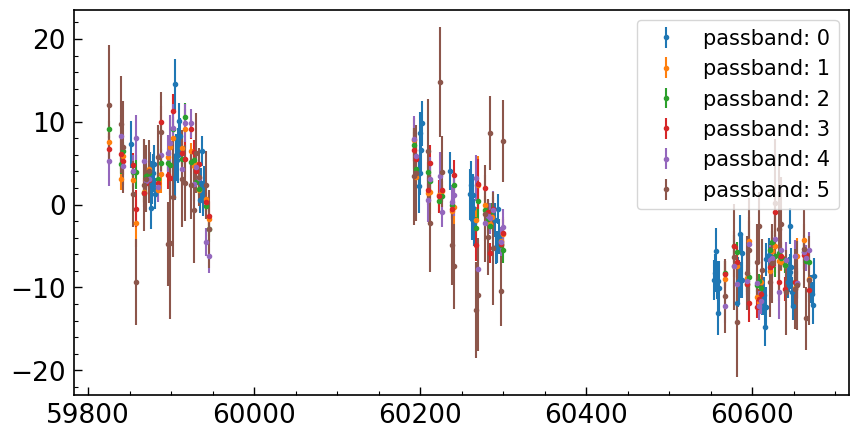

In [9]:
lc = gps.get_group(713)
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
plt.legend(fontsize=15)

In [10]:
best_fit = dho_fit(lc)[1:].reshape((4,6))
np.log(best_fit)

array([[ -1.4818779 ,  -0.52043029,  -1.4293227 ,  -4.72393724,
         -4.81954518, -12.        ],
       [ -7.05956604,  -5.71934959,  -6.39526383, -11.21129564,
        -10.7792018 , -10.8047491 ],
       [ -2.        ,  -1.        ,  -1.77030851, -12.61276008,
        -12.67380407,  -9.70473692],
       [ -2.        ,  -5.0648476 ,  -4.69245662,  -0.21901397,
         -0.2643158 ,  -7.30380924]])

Best_fit model (log): [-1.4818779  -7.05956604 -2.         -2.        ]


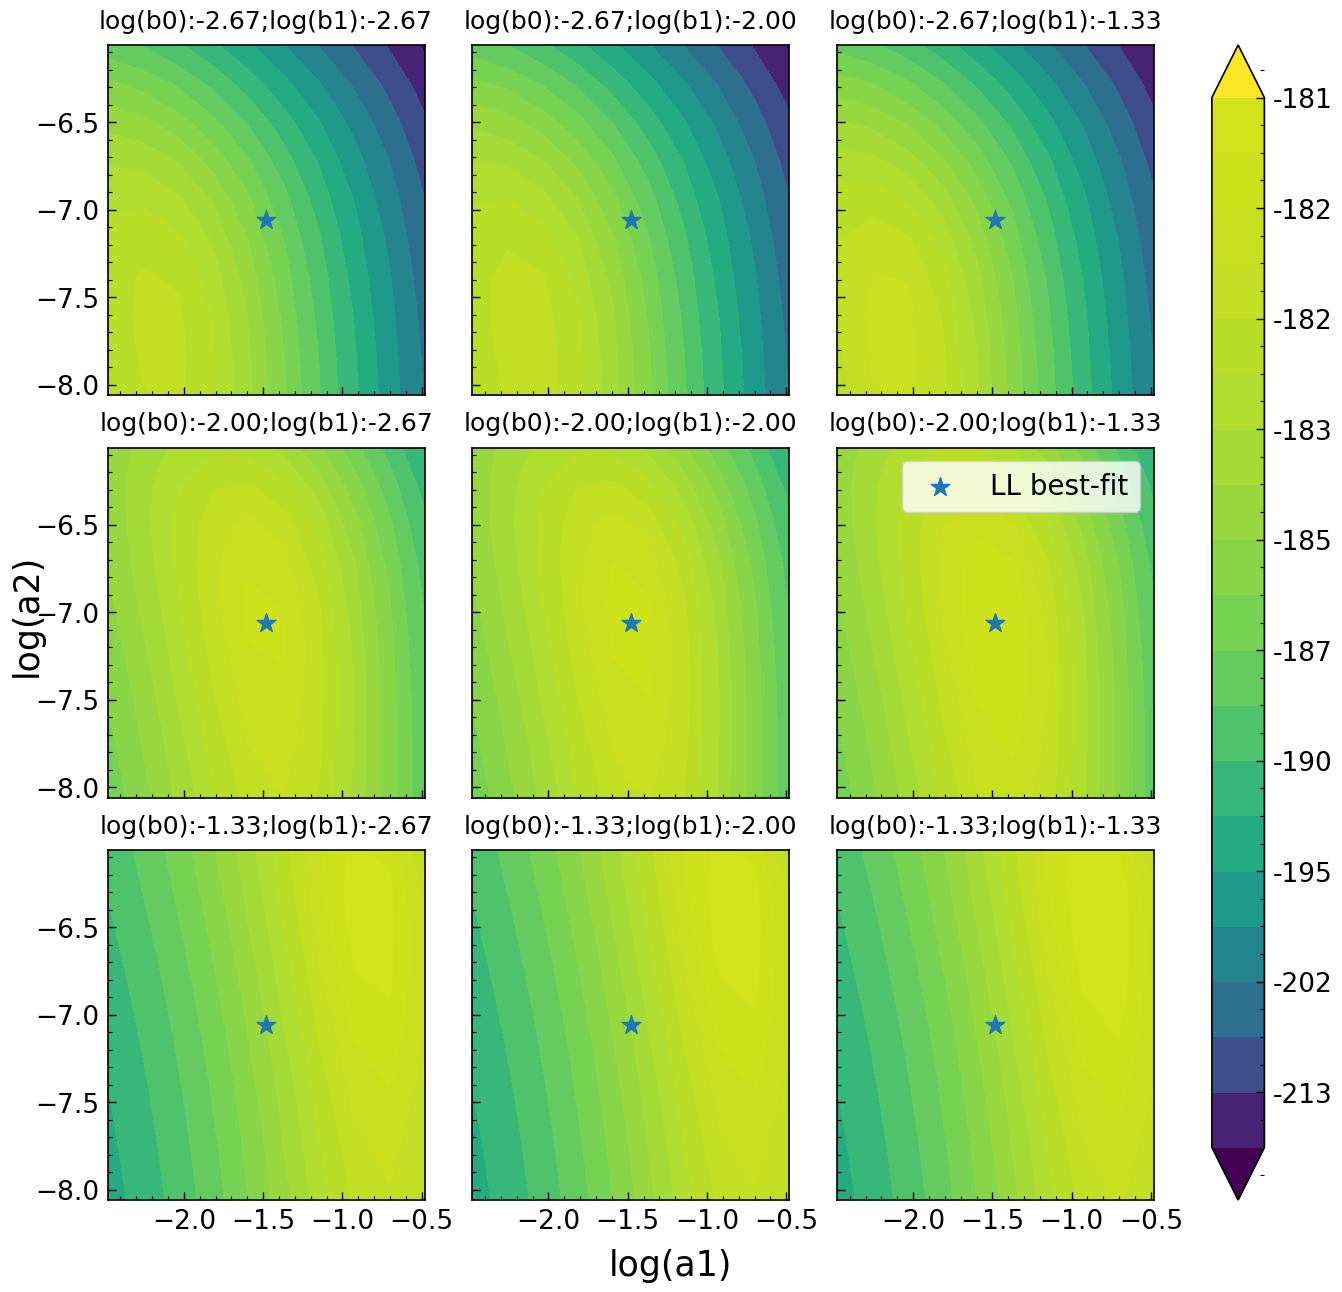

In [11]:
band = 0
lc_g = lc[lc.passband == band]
kernel = DHO_term(*np.log(best_fit[:, band]))
gp = GP(kernel, mean=np.mean(lc_g.flux))

print(f'Best_fit model (log): {np.log(best_fit[:, band])}')
rt = plot_dho_ll(lc_g.mjd.values - lc_g.mjd.values[0], lc_g.flux.values,
            lc_g.flux_err.values, best_fit[:, band], gp, neg_ll, outer_dim=3)

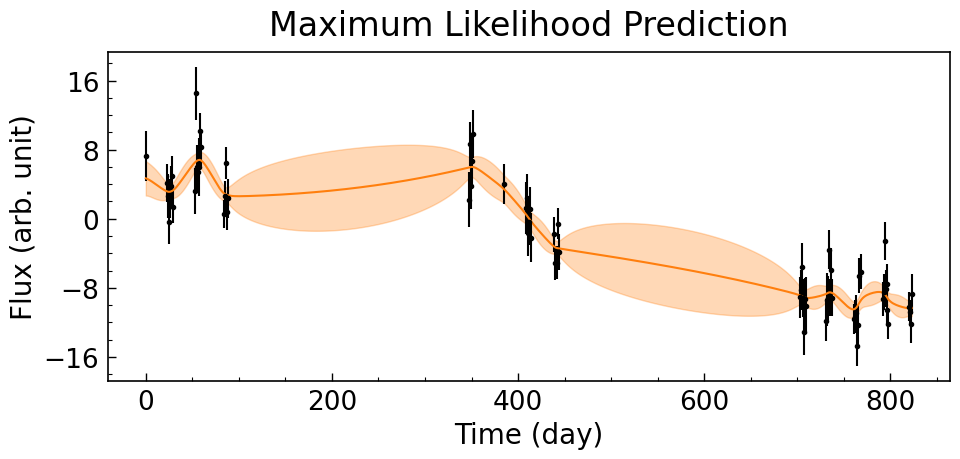

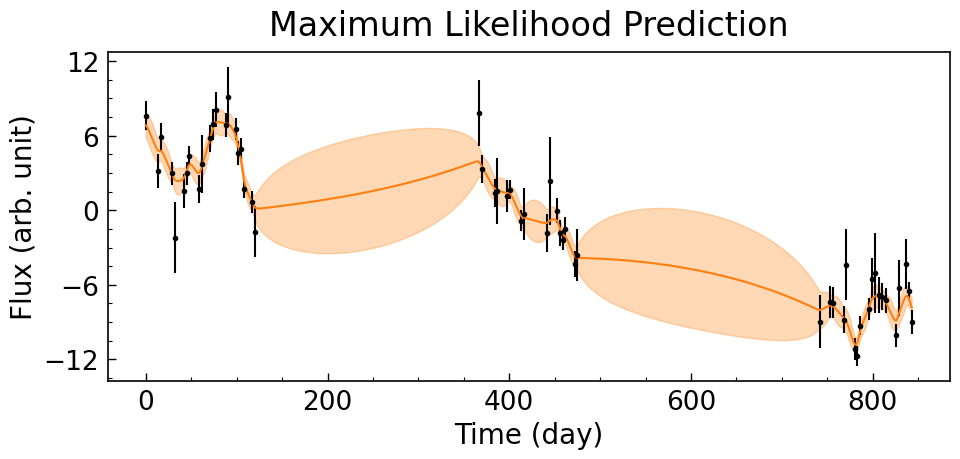

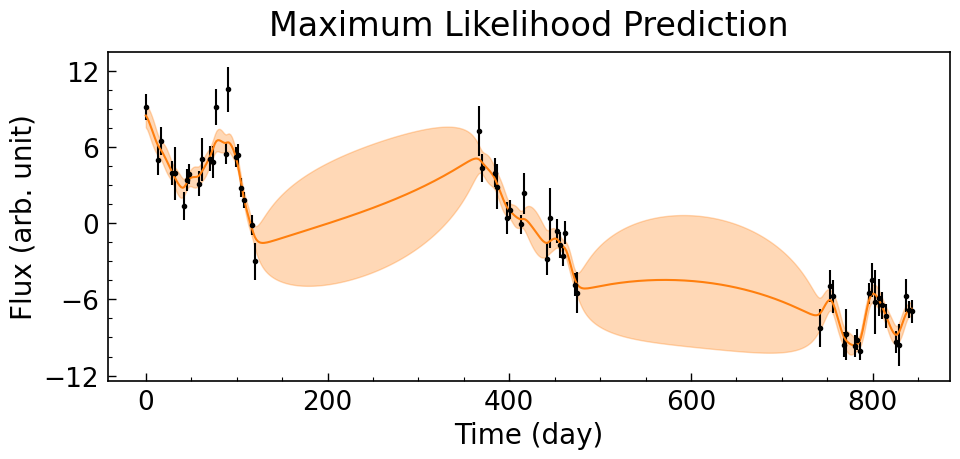

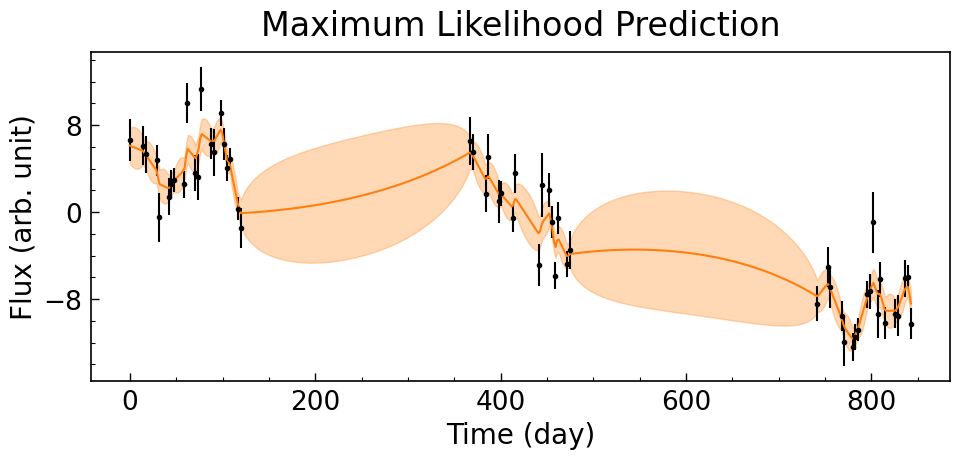

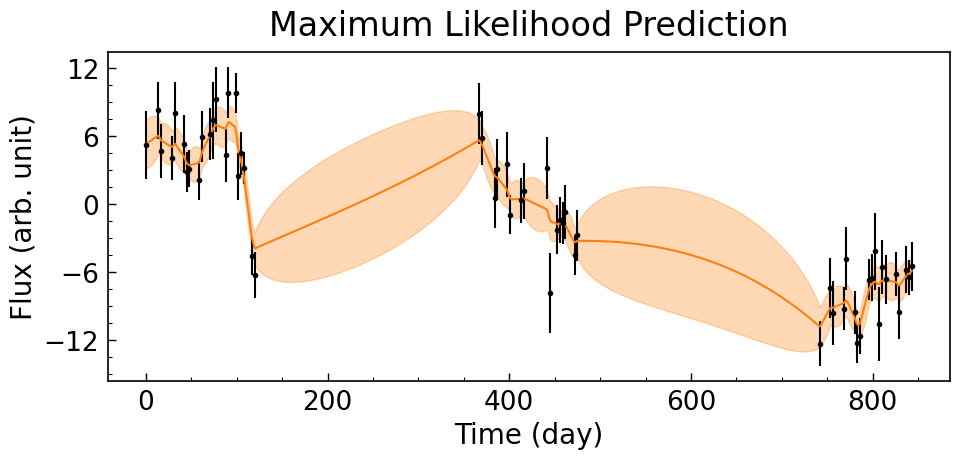

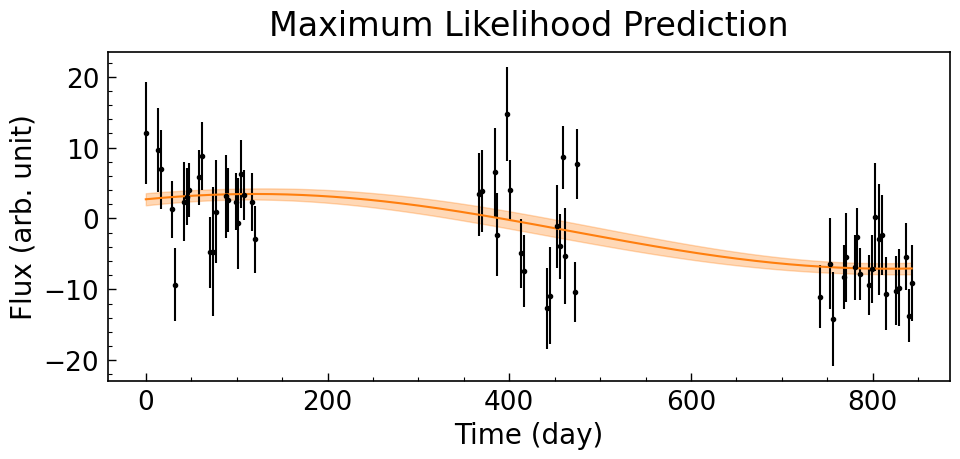

In [12]:
for band in range(0,6):
    lc_g = lc[lc.passband == band]
    plot_pred_dho_lc(lc_g, best_fit[:, band], time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')

<span style='color:red'>__Note:__</span> It seems like for simulated DRW light curves, fitting them with DHO can generate inconsistent fits between light curves in different bands. Also, the difference in ll between panels is not large, and likely to result in the best-fit not getting the 'real' best.

### 3. Look at a few examples of non-AGN variables

#### 3.1 Object: 86456, Targe: 42, Type: Core Collapse Type II SN

In [13]:
train_meta[train_meta.object_id == 86456]

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
506,86456,33.5742,-5.3794,1,0.213,0.219,0.014,40.178,0.017,42,42,3,0.213,40.112,0.001,-65.9,3.1,0.329,59762.879,6,0.0,0.0,0.0,0.0,0.0,0.0


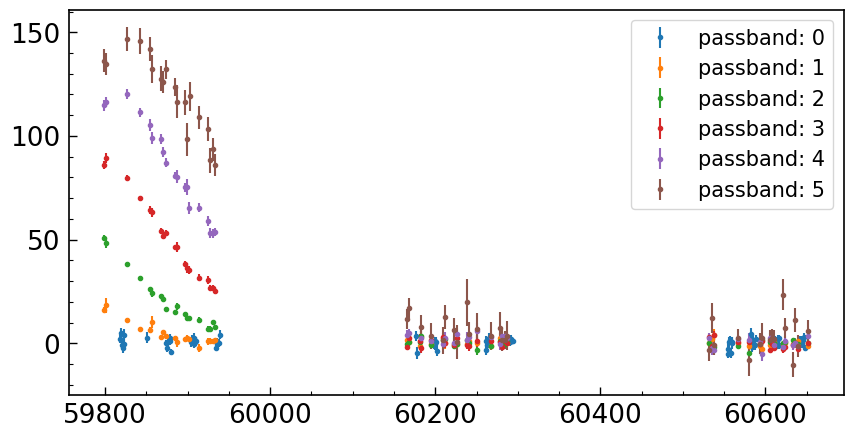

In [14]:
lc = train_lc[train_lc.object_id == 86456].copy()
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
#     scale_y =np.log(lc_per_f.flux+meta[f'tflux_{bands[band]}'].values[0])
#     plt.scatter(lc_per_f.mjd, scale_y - np.mean(scale_y), s=2,
#         label=f'passband: {band}')
plt.legend(fontsize=15)

In [15]:
best_fit = dho_fit(lc)[1:].reshape((4,6))
np.log(best_fit)

array([[-10.        ,  -4.56271398,  -5.68613893,  -5.71313436,
         -4.80875845,  -5.23866394],
       [  1.86119826,  -8.82052035, -10.49792345, -10.12004513,
         -9.65264843, -10.16444195],
       [ -4.79930814,  -4.53050659,  -4.17291128,  -3.90644389,
         -3.19929385,  -3.44107271],
       [ -5.13640974,  -8.96631354,  -5.98950746,  -7.88804344,
         -4.61775075,  -8.76610021]])

Best_fit model (log): [ -5.71313436 -10.12004513  -3.90644389  -7.88804344]


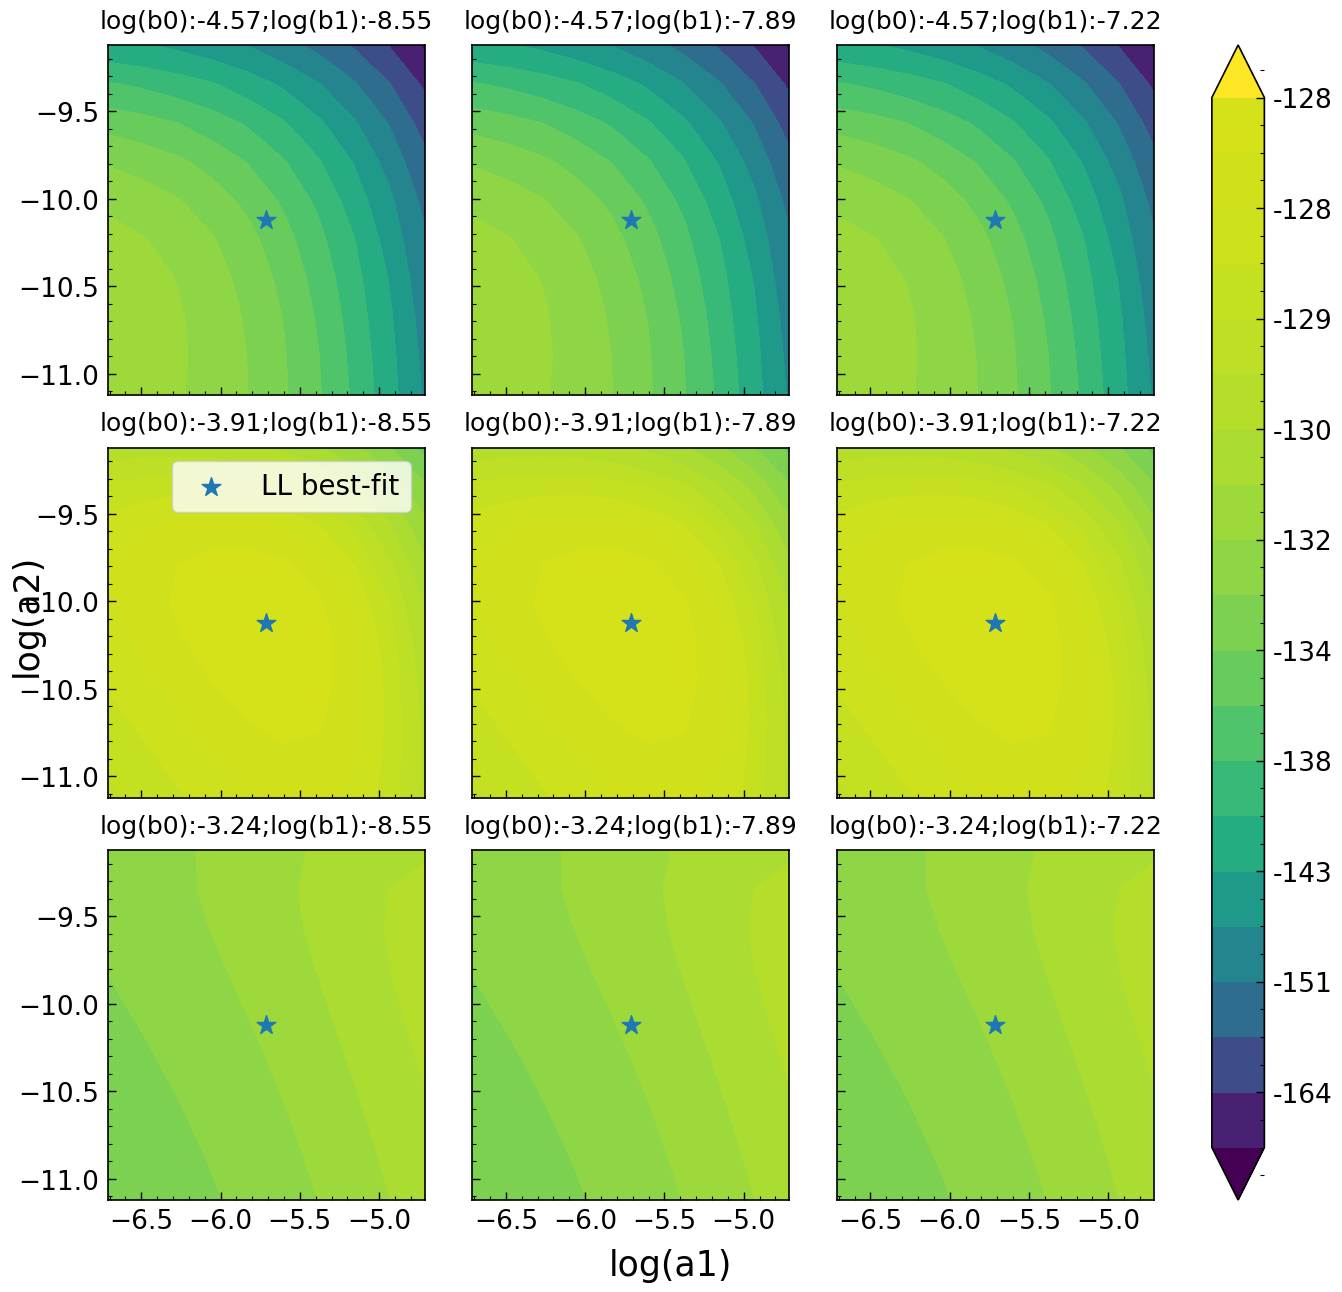

In [16]:
band = 3
lc_g = lc[lc.passband == band]
kernel = DHO_term(*np.log(best_fit[:, band]))
gp = GP(kernel, mean=np.mean(lc_g.flux))

print(f'Best_fit model (log): {np.log(best_fit[:, band])}')
rt = plot_dho_ll(lc_g.mjd.values - lc_g.mjd.values[0], lc_g.flux.values,
            lc_g.flux_err.values, best_fit[:, band], gp, neg_ll, outer_dim=3)

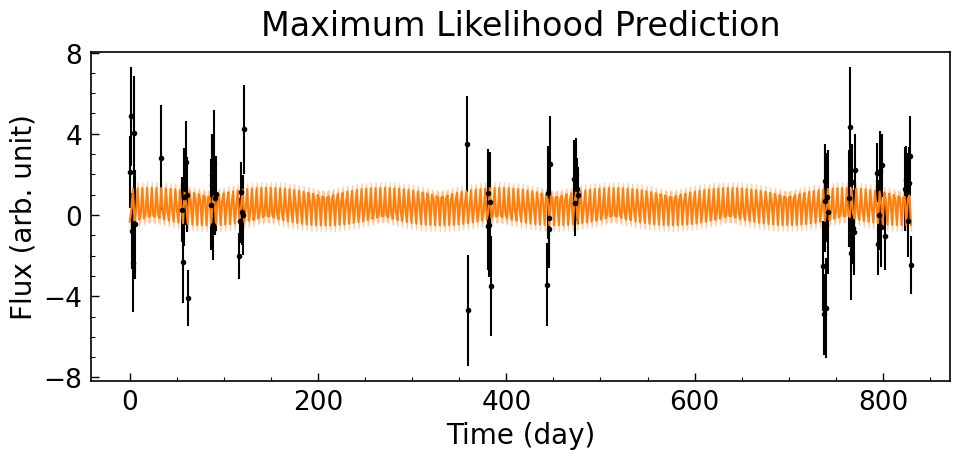

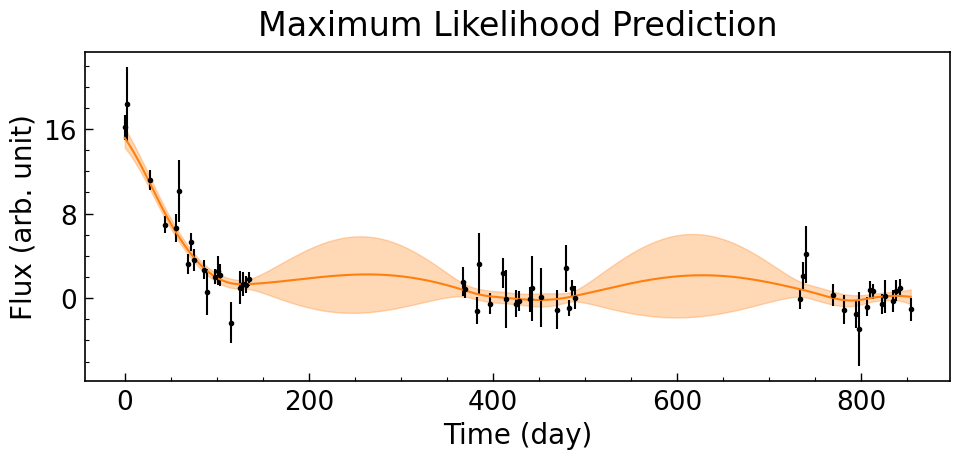

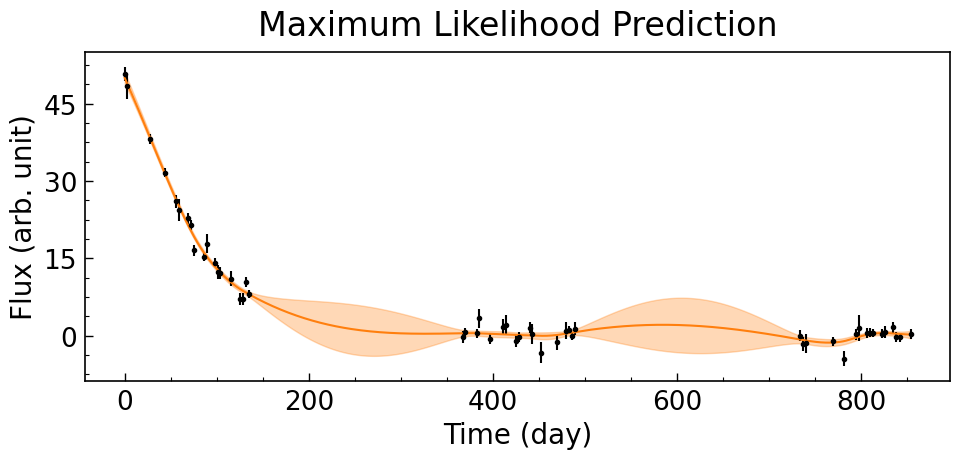

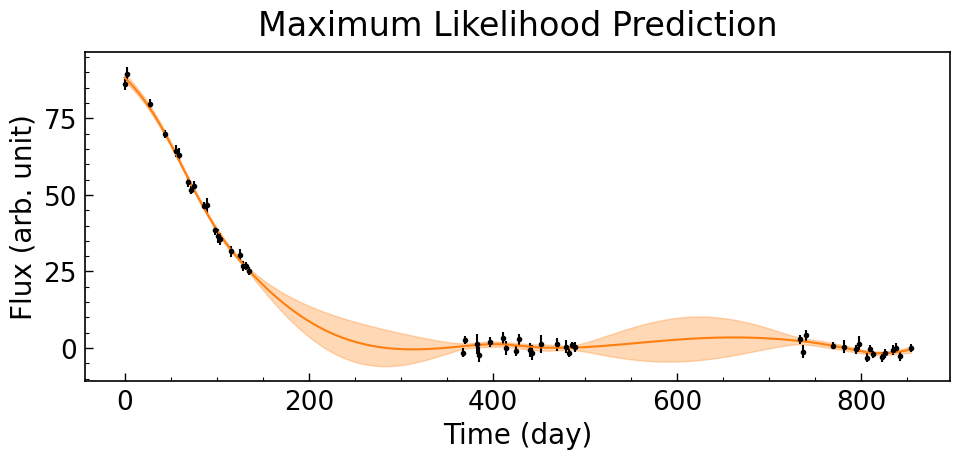

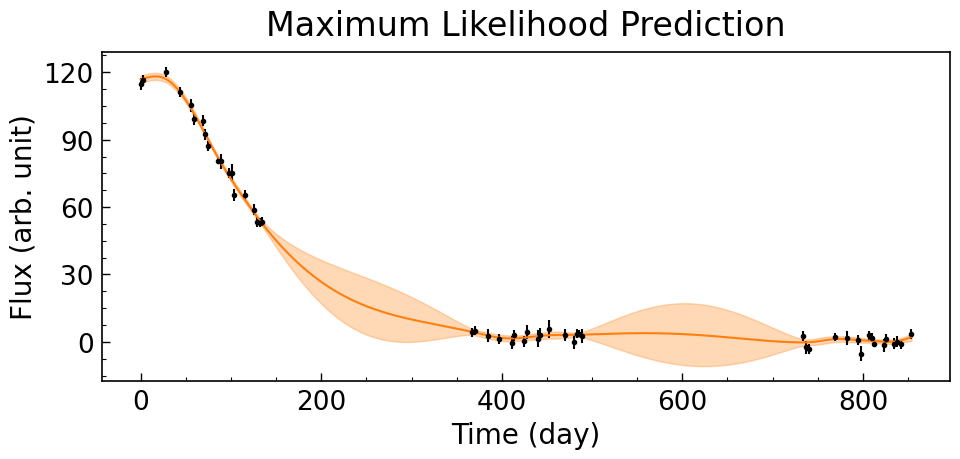

In [17]:
for band in range(0,5):
    lc_g = lc[lc.passband == band]
    plot_pred_dho_lc(lc_g, best_fit[:, band], time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')

#### 3.2 Object: 7698, Target: 90, Type: SNIa

In [18]:
train_meta[train_meta.object_id == 7698]

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
40,7698,347.0134,-62.5086,1,0.263,0.188,0.022,39.801,0.018,90,90,1,0.261,40.61,0.002,112.3,0.0,0.0,59590.891,40,0.0,0.0,0.0,0.0,0.0,0.0


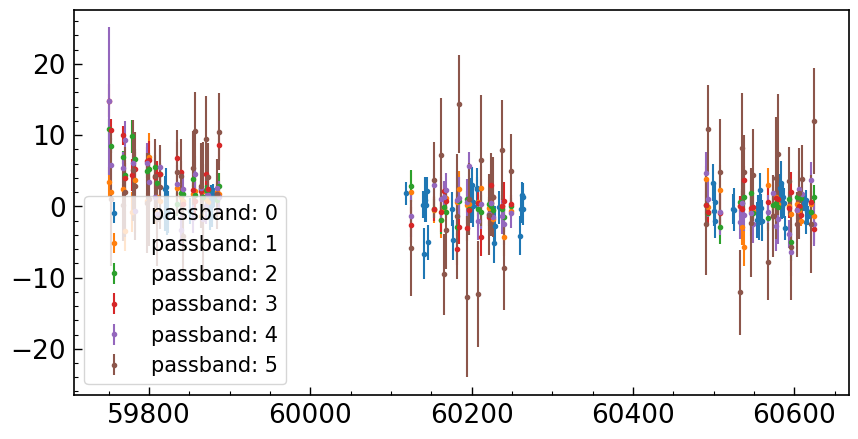

In [19]:
lc = train_lc[train_lc.object_id == 7698].copy()
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
#     scale_y =np.log(lc_per_f.flux+meta[f'tflux_{bands[band]}'].values[0])
#     plt.scatter(lc_per_f.mjd, scale_y - np.mean(scale_y), s=2,
#         label=f'passband: {band}')
plt.legend(fontsize=15)

In [20]:
best_fit = dho_fit(lc)[1:].reshape((4,6))
np.log(best_fit)

array([[-10.        , -10.        ,  -4.08981138,  -2.26461145,
         -3.57909183, -10.        ],
       [ -5.03323755, -11.18334573,  -9.24080177,  -7.68383283,
         -6.93664758,  -8.78263318],
       [ -8.16220816, -10.72288949,  -5.08907644,  -3.26421317,
         -4.30623738,  -8.78458436],
       [ -5.52139506,  -7.3391111 ,  -7.45631198,  -6.5371761 ,
         -5.33269096,  -5.82587909]])

Best_fit model (log): [-10.          -5.03323755  -8.16220816  -5.52139506]


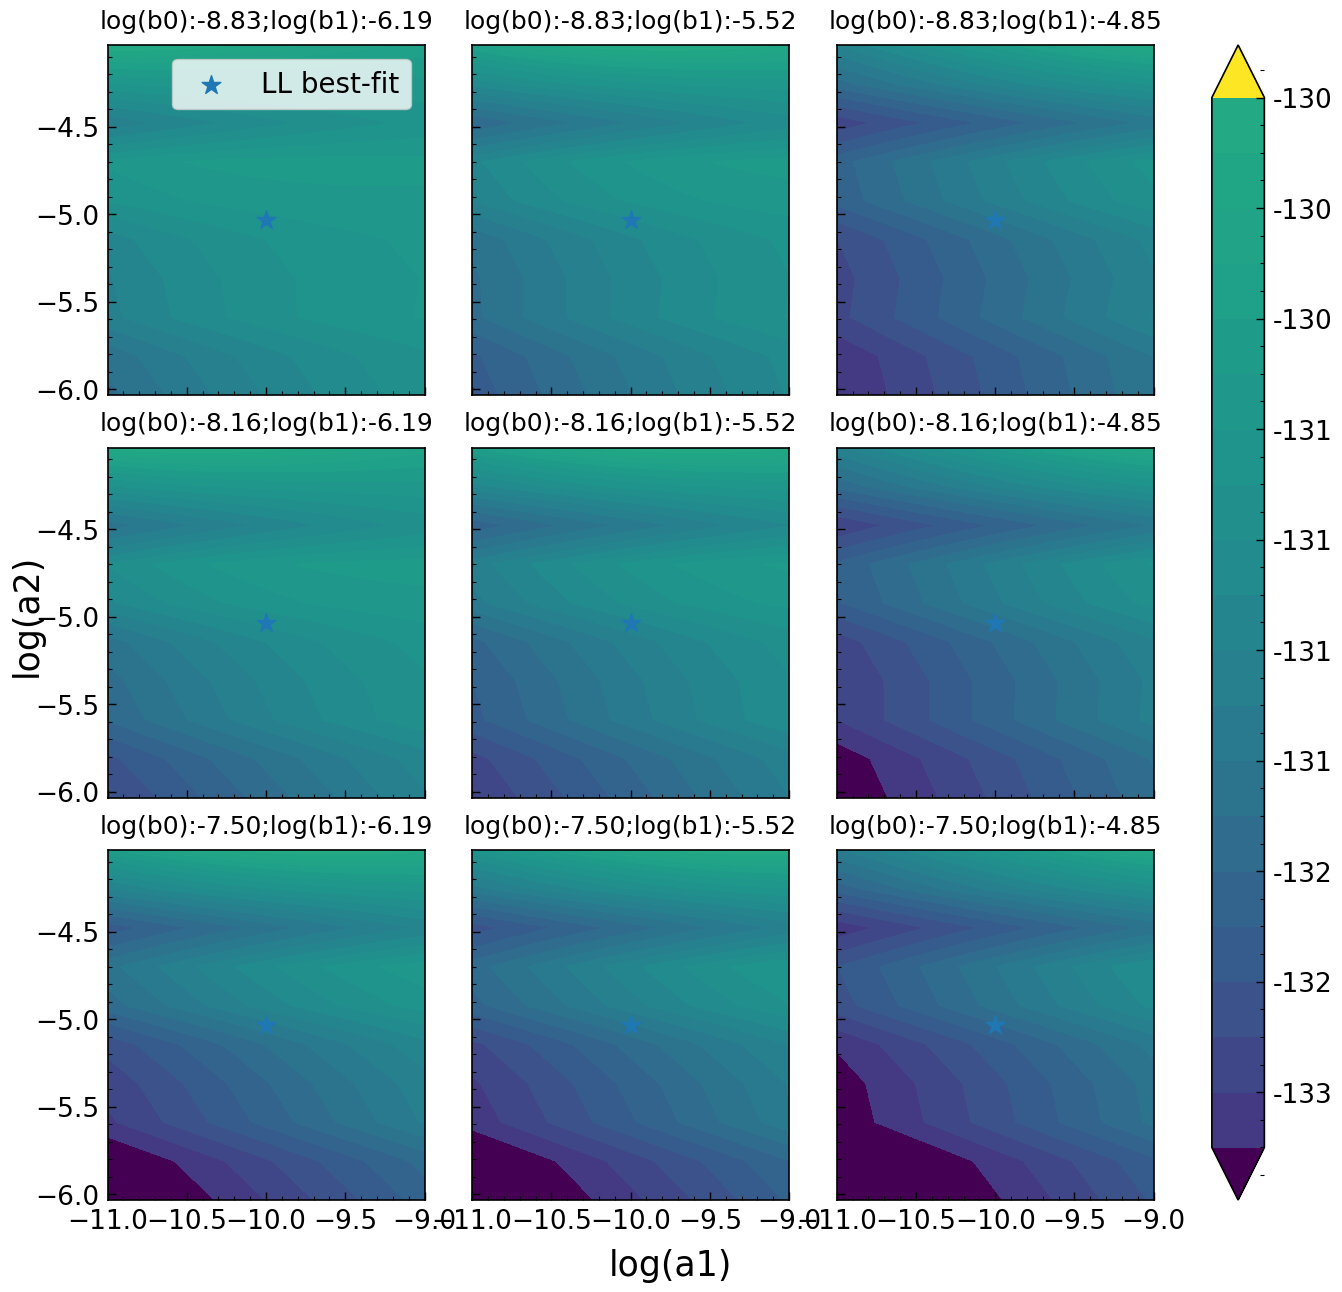

In [21]:
band = 0
lc_g = lc[lc.passband == band]
kernel = DHO_term(*np.log(best_fit[:, band]))
gp = GP(kernel, mean=np.mean(lc_g.flux))

print(f'Best_fit model (log): {np.log(best_fit[:, band])}')
rt = plot_dho_ll(lc_g.mjd.values - lc_g.mjd.values[0], lc_g.flux.values,
            lc_g.flux_err.values, best_fit[:, band], gp, neg_ll, outer_dim=3)

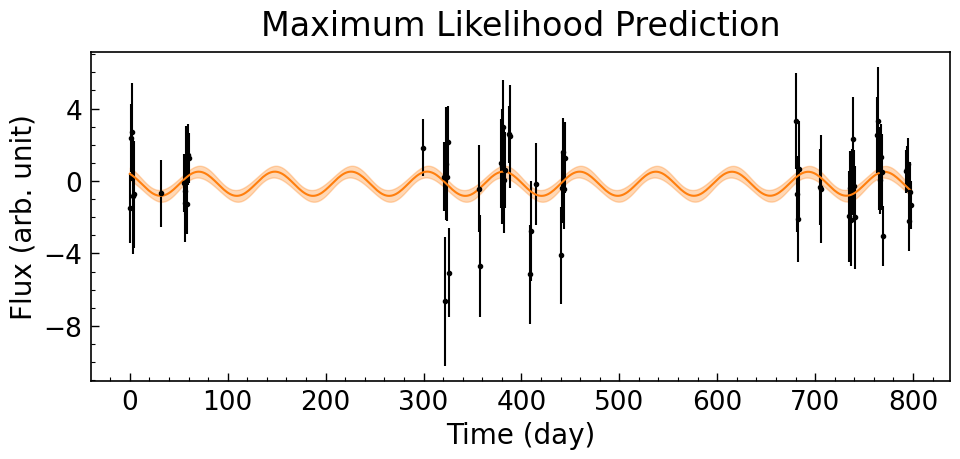

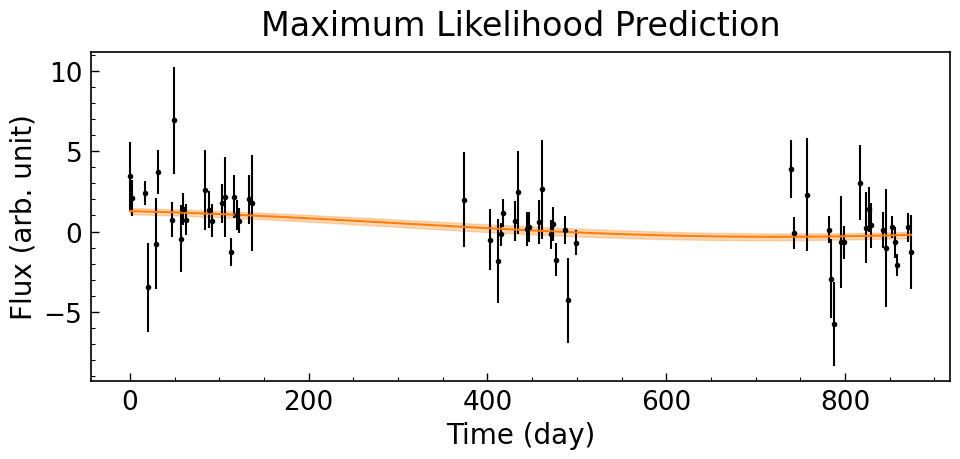

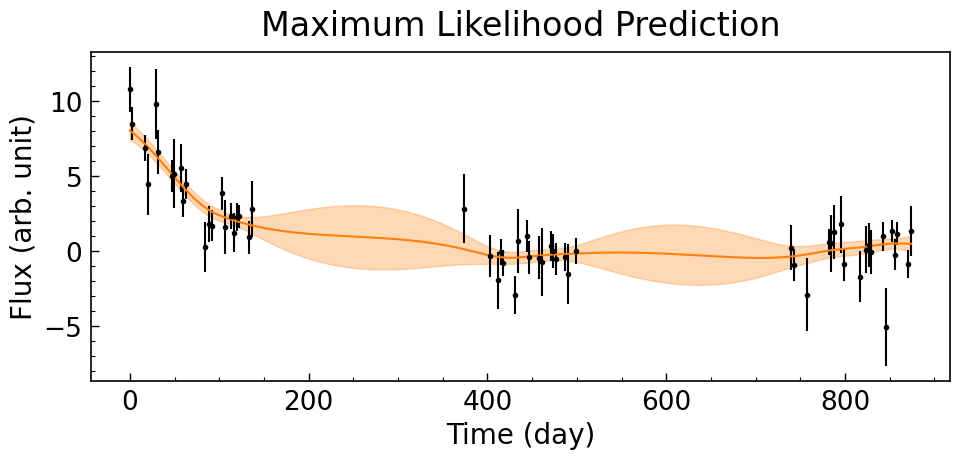

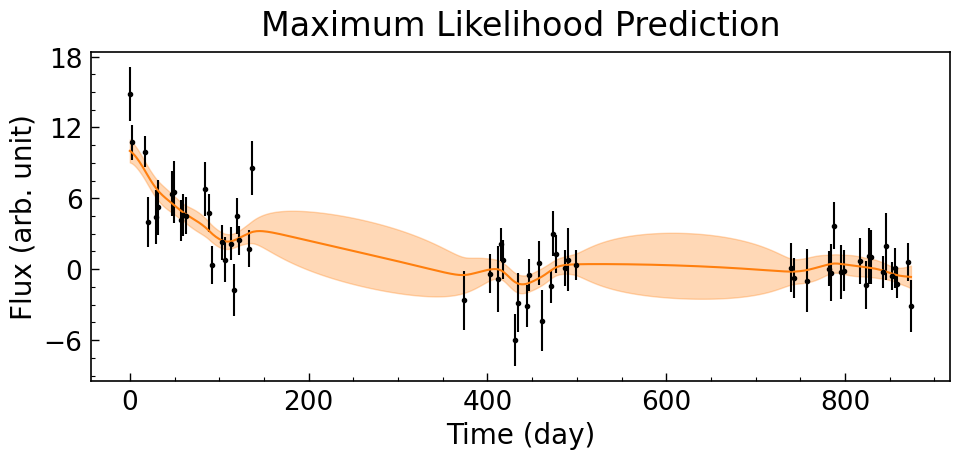

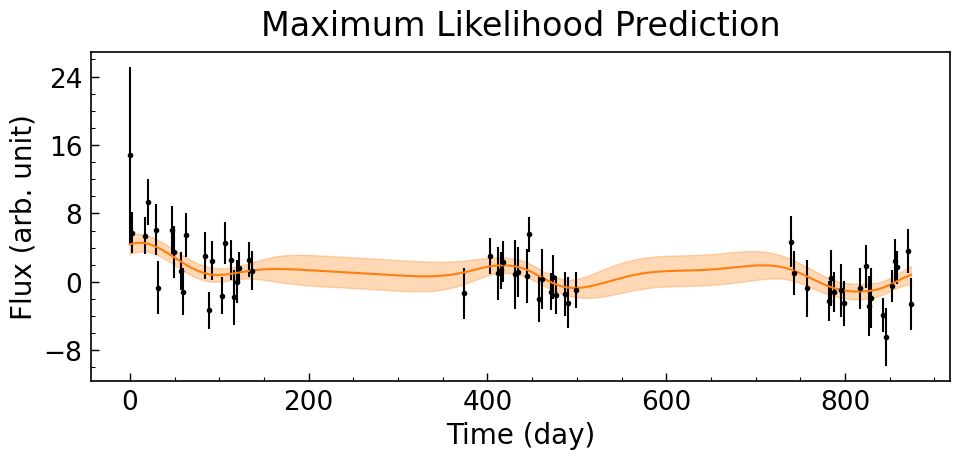

In [22]:
for band in range(0,5):
    lc_g = lc[lc.passband == band]
    plot_pred_dho_lc(lc_g, best_fit[:, band], time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')

#### 3.3 Object: 18645, Target: 62, Type: Core Collapse, Type Ibc SN

In [23]:
train_meta[train_meta.object_id == 18645]

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
110,18645,358.6364,-46.7685,1,0.164,2.303,1.102,46.331,0.008,62,62,1,0.164,39.479,-0.001,278.1,0.0,0.0,60380.27,77,0.0,0.0,0.0,0.0,0.0,0.0


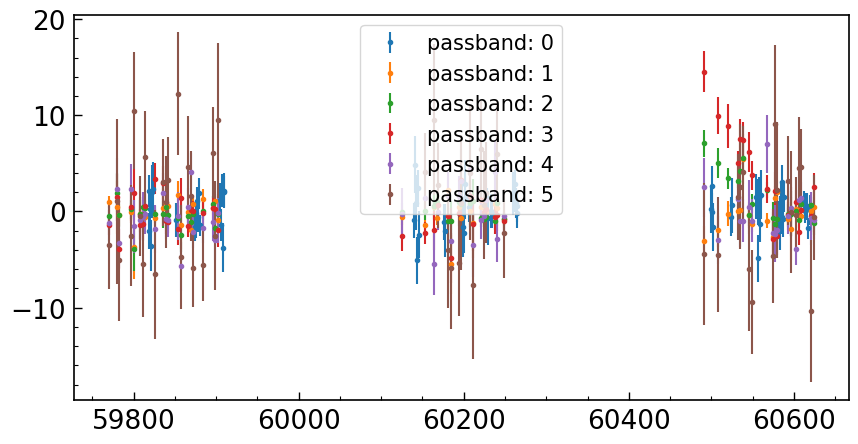

In [24]:
lc = train_lc[train_lc.object_id == 18645].copy()
max_err = np.percentile(lc.flux_err, 99)
lc = lc[lc.flux_err < max_err]
fig = plt.figure(figsize=(10,5))
for band in range(6):
    lc_per_f = lc[lc.passband == band]
    plt.errorbar(lc_per_f.mjd, lc_per_f.flux, lc_per_f.flux_err, fmt='.',
        label=f'passband: {band}')
#     scale_y =np.log(lc_per_f.flux+meta[f'tflux_{bands[band]}'].values[0])
#     plt.scatter(lc_per_f.mjd, scale_y - np.mean(scale_y), s=2,
#         label=f'passband: {band}')
plt.legend(fontsize=15)

In [25]:
best_fit = dho_fit(lc)[1:].reshape((4,6))
np.log(best_fit)

array([[-10.        ,  -9.05615026,  -4.21717911,  -3.95591361,
        -10.        , -10.        ],
       [  2.57573058,  -0.56082458,  -8.13068371,  -7.90495448,
         -2.68726883,  -2.15157662],
       [ -3.98113599,  -5.66610384,  -5.32495213,  -4.15935362,
         -7.01973909, -10.03841892],
       [-10.35314881,  -5.56186984,  -8.78403929, -10.62111114,
         -5.0189481 ,  -4.17499677]])

Best_fit model (log): [-4.21717911 -8.13068371 -5.32495213 -8.78403929]


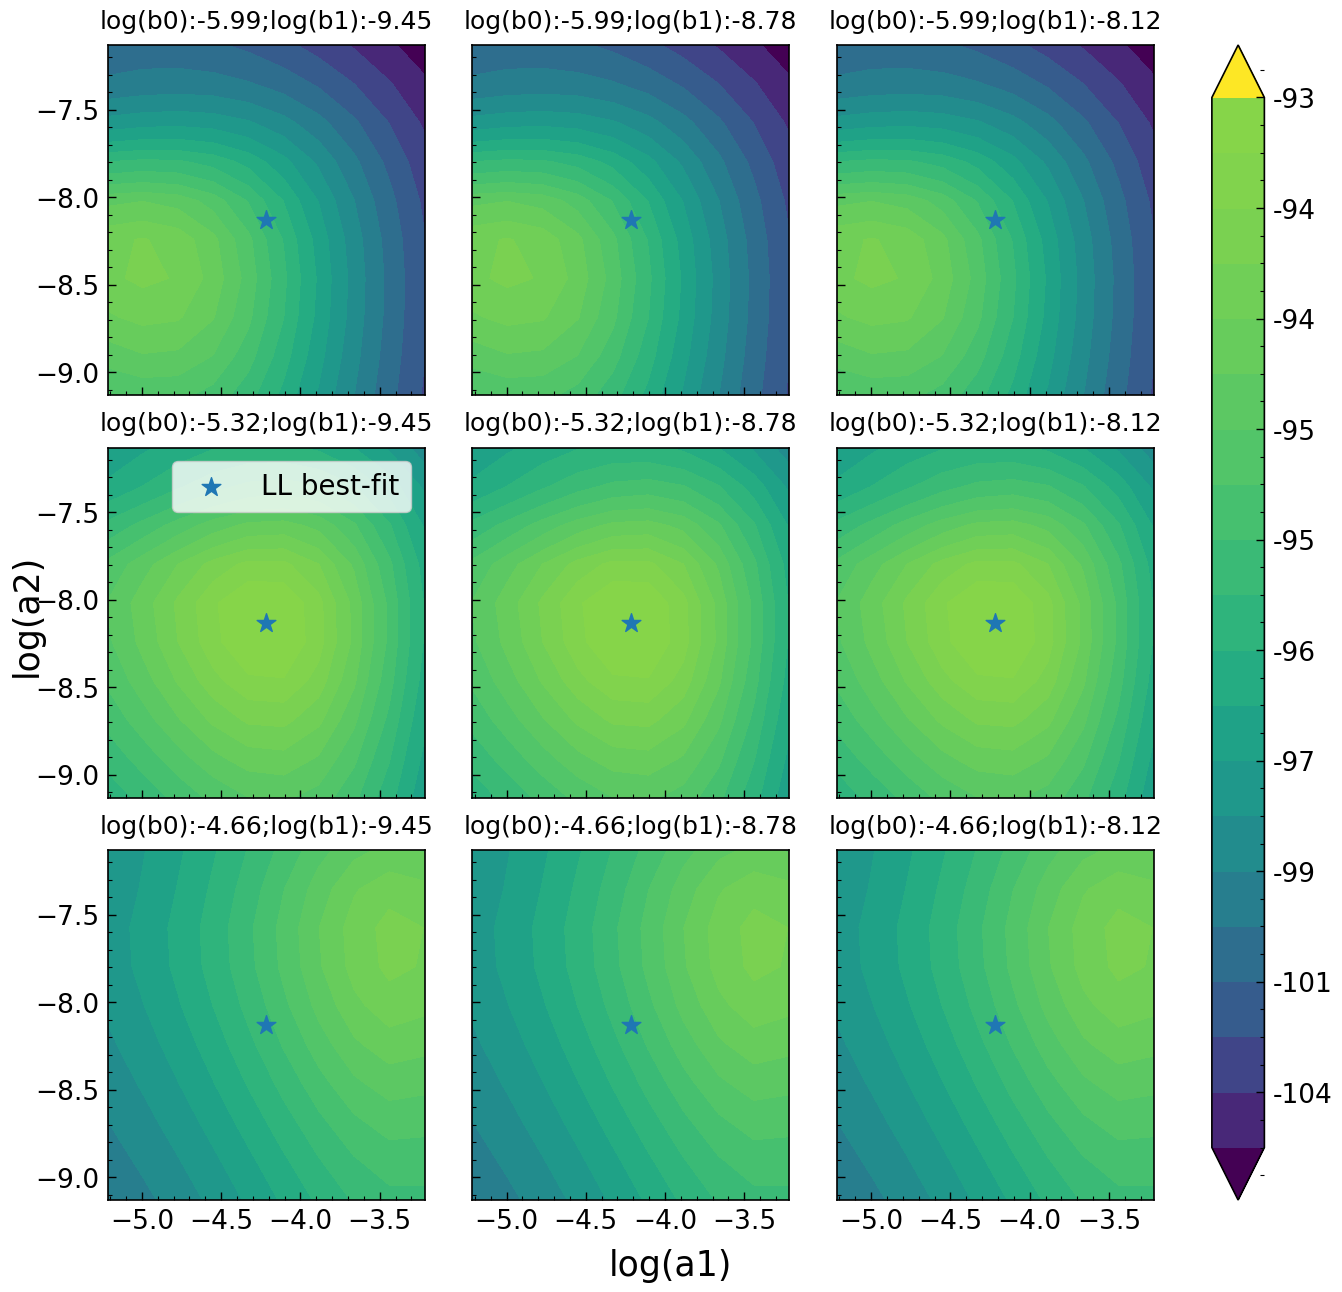

In [26]:
band = 2
lc_g = lc[lc.passband == band]
kernel = DHO_term(*np.log(best_fit[:, band]))
gp = GP(kernel, mean=np.mean(lc_g.flux))

print(f'Best_fit model (log): {np.log(best_fit[:, band])}')
rt = plot_dho_ll(lc_g.mjd.values - lc_g.mjd.values[0], lc_g.flux.values,
            lc_g.flux_err.values, best_fit[:, band], gp, neg_ll, outer_dim=3)

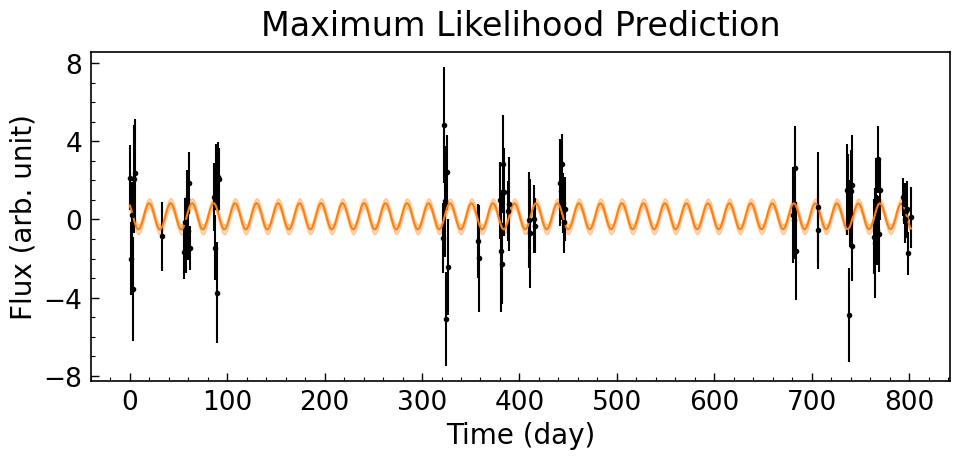

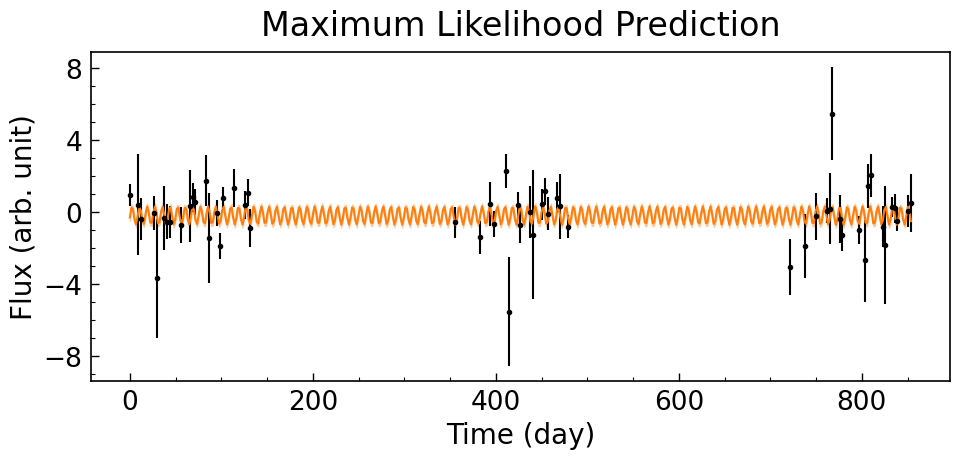

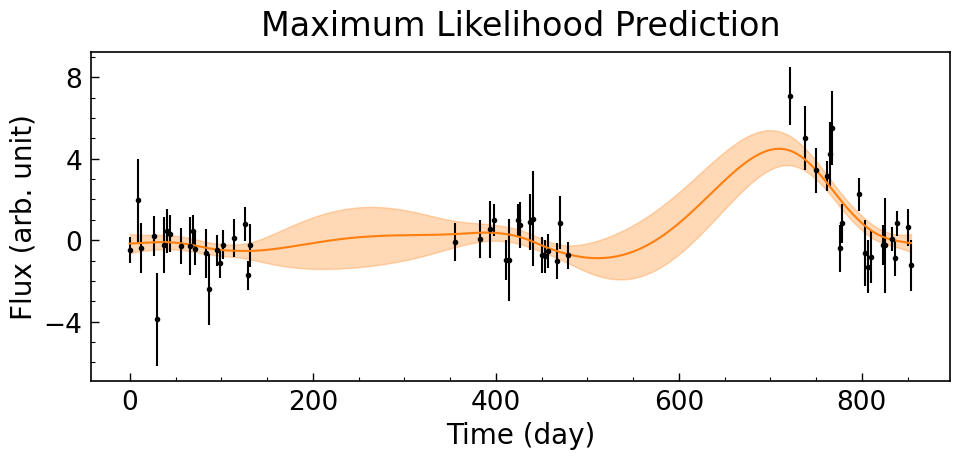

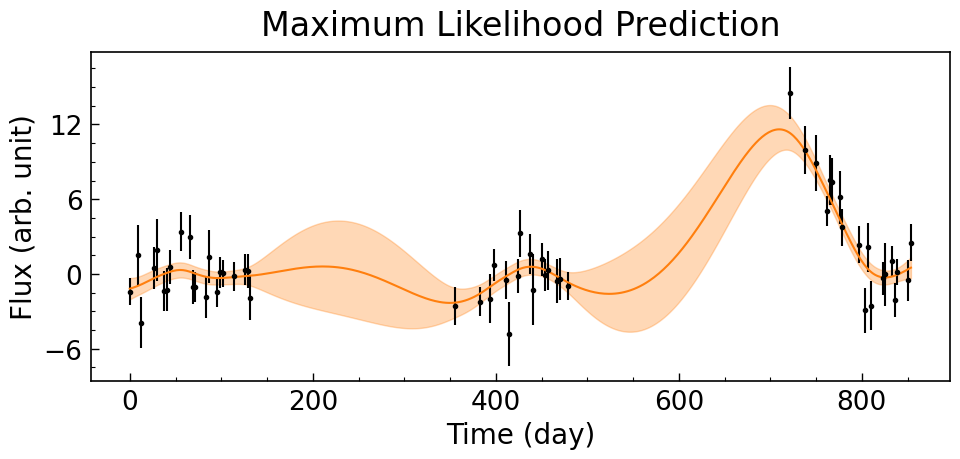

In [27]:
for band in range(0,4):
    lc_g = lc[lc.passband == band]
    plot_pred_dho_lc(lc_g, best_fit[:, band], time_col='mjd', 
                     y_col='flux', yerr_col='flux_err')

<span style='color:red'>__Conclusion:__</span> 
- Light curves with very low amplitude (comparable to noise level) can't achieve reliable/consistent DHO fits, but most of them find the best solution as a combination of sinusoidal waves. 
- DHO seems to provide better predicted light curves for SNe, in terms of shape and the precision. 
- Fitting simulated DRW light curves with DHO will generate inconsistent results (e.g., between bands)